**01_Data_understanding**

In [28]:
import os
import shutil

# 1. Crear la carpeta faltante
os.makedirs('01_data_understanding', exist_ok=True)
print("✅ Carpeta '01_data_understanding' creada.")

# 2. Mover tu notebook original ahí
# Buscamos tu archivo (puede llamarse 'Nota3 Machine.ipynb' o similar)
nombre_notebook = 'Nota3 Machine.ipynb'

if os.path.exists(nombre_notebook):
    # Lo movemos y renombramos a algo más técnico como 'eda_analisis.ipynb'
    destino = os.path.join('01_data_understanding', 'eda_analisis.ipynb')
    shutil.move(nombre_notebook, destino)
    print(f"✅ Archivo movido a: {destino}")
else:
    print(f"⚠️ No encontré el archivo '{nombre_notebook}' en la raíz.")
    print("   -> Por favor, arrastra manualmente tu notebook a la carpeta '01_data_understanding' en el panel de la izquierda.")

✅ Carpeta '01_data_understanding' creada.
⚠️ No encontré el archivo 'Nota3 Machine.ipynb' en la raíz.
   -> Por favor, arrastra manualmente tu notebook a la carpeta '01_data_understanding' en el panel de la izquierda.


**02_Data_Preparation**

In [ ]:
%%writefile 02_data_preparation/feature_engineering.py
import pandas as pd
import numpy as np

def crear_features_agregadas(df_installments, df_bureau):
    """
    Crea características complejas a partir de tablas secundarias.
    """
    # --- 1. Agregaciones de Historial de Pagos (Installments) ---
    print("   -> Procesando historial de pagos...")
    df_inst = df_installments.copy()
    df_inst['PAYMENT_DIFF'] = df_inst['AMT_INSTALMENT'] - df_inst['AMT_PAYMENT']
    df_inst['DPD'] = df_inst['DAYS_ENTRY_PAYMENT'] - df_inst['DAYS_INSTALMENT']
    df_inst['DPD'] = df_inst['DPD'].apply(lambda x: x if x > 0 else 0)

    agg_installments = df_inst.groupby('SK_ID_CURR').agg({
        'PAYMENT_DIFF': ['mean', 'max'],
        'DPD': ['mean', 'sum'],
        'AMT_PAYMENT': ['sum']
    })
    # Aplanar nombres
    agg_installments.columns = ['INST_' + '_'.join(col).upper() for col in agg_installments.columns.values]
    agg_installments.reset_index(inplace=True)

    # --- 2. Agregaciones de Buró de Crédito (Bureau) ---
    # Esta es la parte nueva que solicitaste
    if df_bureau is not None:
        print("   -> Procesando datos del buró...")
        df_bur = df_bureau.copy()

        # Crear variable: ¿Está el crédito activo?
        df_bur['CREDIT_ACTIVE_BINARY'] = df_bur['CREDIT_ACTIVE'].apply(lambda x: 1 if x == 'Active' else 0)

        agg_bureau = df_bur.groupby('SK_ID_CURR').agg({
            'SK_ID_BUREAU': ['count'],           # Cantidad de créditos previos
            'AMT_CREDIT_SUM': ['sum', 'mean'],   # Total deuda externa
            'AMT_CREDIT_SUM_OVERDUE': ['sum'],   # Total deuda vencida
            'CREDIT_ACTIVE_BINARY': ['mean']     # % de créditos activos
        })

        agg_bureau.columns = ['BUREAU_' + '_'.join(col).upper() for col in agg_bureau.columns.values]
        agg_bureau.reset_index(inplace=True)

        # Unimos installments y bureau en un solo dataframe de features
        df_features = agg_installments.merge(agg_bureau, on='SK_ID_CURR', how='outer')
    else:
        df_features = agg_installments

    return df_features

def preparar_dataset_final(df_app, df_features):
    # Unir tabla principal con las features generadas
    print("   -> Uniendo tabla principal con features generadas...")
    df_final = df_app.merge(df_features, on='SK_ID_CURR', how='left')

    # Llenar nulos con 0 (asumiendo que si no hay datos, no hay deuda/atraso)
    df_final = df_final.fillna(0)

    return df_final

Overwriting 02_data_preparation/feature_engineering.py


**03_Modeling**

In [ ]:
%%writefile 03_modeling/train_model.py
import pandas as pd
import joblib
import os
import sys

# --- CONFIGURACIÓN DE RUTAS ---
current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '02_data_preparation'))

try:
    import feature_engineering as fe
except ImportError as e:
    print(f"❌ Error importando módulo: {e}")
    sys.exit(1)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

def entrenar_modelo():
    print("🚀 INICIANDO PIPELINE DE ENTRENAMIENTO")

    # Directorio donde están los parquet (Raíz o carpeta data)
    # Ajusta esto si tus archivos están en otra carpeta
    data_dir = current_dir

    # 1. Carga de Datos
    print("\n1. Cargando archivos Parquet...")
    try:
        df_app = pd.read_parquet(os.path.join(data_dir, 'application_.parquet'))
        df_inst = pd.read_parquet(os.path.join(data_dir, 'installments_payments.parquet'))
        df_bureau = pd.read_parquet(os.path.join(data_dir, 'bureau.parquet'))
        print(f"   ✅ Application: {df_app.shape}")
        print(f"   ✅ Installments: {df_inst.shape}")
        print(f"   ✅ Bureau: {df_bureau.shape}")
    except FileNotFoundError as e:
        print(f"   ❌ FATAL: No se encontró el archivo: {e.filename}")
        print("   Asegúrate de subir los 3 archivos .parquet al entorno de Colab.")
        return

    # 2. Ingeniería de Características
    print("\n2. Generando Features Agregadas (Installments + Bureau)...")
    df_agg = fe.crear_features_agregadas(df_inst, df_bureau)

    # 3. Consolidación del Dataset
    print("\n3. Creando Dataset Maestro...")
    df_completo = fe.preparar_dataset_final(df_app, df_agg)

    # Selección de Variables para el Modelo
    # Incluimos las nuevas variables generadas que empiezan con INST_ o BUREAU_
    features_base = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'CNT_CHILDREN', 'DAYS_EMPLOYED', 'DAYS_BIRTH']
    features_generadas = [col for col in df_completo.columns if col.startswith('INST_') or col.startswith('BUREAU_')]

    features_finales = features_base + features_generadas
    target = 'TARGET'

    # Filtramos solo las columnas que existen (por seguridad)
    features_existentes = [f for f in features_finales if f in df_completo.columns]

    X = df_completo[features_existentes]
    y = df_completo[target]

    print(f"   -> Entrenando con {len(features_existentes)} variables explicativas.")

    # 4. Split Train/Test
    print("\n4. Separando Train/Test (80/20)...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 5. Entrenamiento
    print("\n5. Entrenando Random Forest...")
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', RandomForestClassifier(n_estimators=60, max_depth=10, random_state=42, class_weight='balanced', n_jobs=-1))
    ])

    pipeline.fit(X_train, y_train)

    # Validación rápida
    score = pipeline.score(X_test, y_test)
    print(f"   -> Accuracy en Test: {score:.4f}")

    # 6. Guardado
    print("\n6. Guardando artefactos...")
    artifacts_path = os.path.join(current_dir, 'artifacts')
    os.makedirs(artifacts_path, exist_ok=True)

    joblib.dump(pipeline, os.path.join(artifacts_path, 'model.joblib'))
    joblib.dump(features_existentes, os.path.join(artifacts_path, 'features.joblib'))

    print(f"✅ ¡PROCESO COMPLETADO! Modelo guardado en {artifacts_path}")

if __name__ == "__main__":
    entrenar_modelo()

Overwriting 03_modeling/train_model.py


In [ ]:
!python 03_modeling/train_model.py

🚀 INICIANDO PIPELINE DE ENTRENAMIENTO

1. Cargando archivos Parquet...
   ✅ Application: (307511, 122)
   ✅ Installments: (13605401, 8)
   ✅ Bureau: (1716428, 17)

2. Generando Features Agregadas (Installments + Bureau)...
   -> Procesando historial de pagos...
   -> Procesando datos del buró...

3. Creando Dataset Maestro...
   -> Uniendo tabla principal con features generadas...
   -> Entrenando con 16 variables explicativas.

4. Separando Train/Test (80/20)...

5. Entrenando Random Forest...
   -> Accuracy en Test: 0.6775

6. Guardando artefactos...
✅ ¡PROCESO COMPLETADO! Modelo guardado en /content/artifacts


**04_Evaluation**

In [ ]:
%%writefile 04_evaluation/evaluate_model.py
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import os
import sys

# Configuración de rutas
current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '02_data_preparation')) # Para importar feature_engineering

try:
    import feature_engineering as fe
except ImportError:
    # Intento alternativo de importación si se ejecuta desde la raíz
    sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '02_data_preparation')))
    import feature_engineering as fe

def evaluar():
    print("📊 Iniciando Evaluación del Modelo...")

    # 1. Cargar Datos y Artefactos
    artifacts_path = os.path.join(current_dir, 'artifacts')
    data_path = current_dir # O '../data' si moviste los archivos

    try:
        pipeline = joblib.load(os.path.join(artifacts_path, 'model.joblib'))
        features = joblib.load(os.path.join(artifacts_path, 'features.joblib'))

        # Cargamos datos para recrear el test set
        # (Idealmente deberíamos haber guardado X_test, pero por simplicidad recargamos)
        df_app = pd.read_parquet(os.path.join(data_path, 'application_.parquet'))
        df_inst = pd.read_parquet(os.path.join(data_path, 'installments_payments.parquet'))
        df_bureau = pd.read_parquet(os.path.join(data_path, 'bureau.parquet'))
    except Exception as e:
        print(f"❌ Error cargando archivos: {e}")
        return

    # 2. Preprocesamiento (Igual que en training)
    print("   -> Regenerando features para evaluación...")
    df_agg = fe.crear_features_agregadas(df_inst, df_bureau)
    df_completo = fe.preparar_dataset_final(df_app, df_agg)

    # Filtrar y preparar X, y
    # Aseguramos que existan todas las columnas
    cols_existentes = [f for f in features if f in df_completo.columns]
    X = df_completo[cols_existentes]
    y = df_completo['TARGET']

    # Split (Mismo random_state que training para asegurar que el test set sea el mismo)
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 3. Predicciones
    print("   -> Generando predicciones...")
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # 4. Generar Reportes y Gráficos
    output_dir = os.path.join(current_dir, 'reports')
    os.makedirs(output_dir, exist_ok=True)

    # --- Matriz de Confusión ---
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buen Pagador', 'Moroso'])
    disp.plot(cmap='Blues')
    plt.title('Matriz de Confusión')
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
    plt.close()

    # --- Curva ROC ---
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Curva ROC')
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'roc_curve.png'))
    plt.close()

    # --- Reporte de Texto ---
    report = classification_report(y_test, y_pred)
    with open(os.path.join(output_dir, 'metrics_report.txt'), 'w') as f:
        f.write("REPORTE DE CLASIFICACIÓN\n")
        f.write("========================\n\n")
        f.write(report)
        f.write(f"\nAUC Score: {auc:.4f}")

    print(f"✅ Evaluación completada. Reportes guardados en: {output_dir}")

if __name__ == "__main__":
    evaluar()

Writing 04_evaluation/evaluate_model.py


In [ ]:
import threading
import time
import requests
import uvicorn
import sys
import os

# --- CORRECCIÓN DEL IMPORT ---
# Como la carpeta '05_deployment' empieza con número, no podemos hacer "import 05_..."
# Solución: Agregamos esa carpeta temporalmente a las rutas donde Python busca código.
sys.path.append(os.path.join(os.getcwd(), '05_deployment'))

try:
    from app import app # Ahora sí encuentra 'app.py' dentro de la carpeta
    print("✅ API importada correctamente.")
except ImportError as e:
    print(f"❌ Error importando la API: {e}")

# 1. Función para correr el servidor en un hilo separado
def run_server():
    # Ejecutamos la app que acabamos de importar
    uvicorn.run(app, host="127.0.0.1", port=8000)

# Iniciar servidor en background
# Usamos un nombre único para el hilo para evitar conflictos si ejecutas la celda varias veces
thread = threading.Thread(target=run_server, name="UvicornThread")
thread.daemon = True
thread.start()

# Esperar unos segundos a que inicie
print("⏳ Iniciando servidor API...")
time.sleep(5)

# 2. PROBAR LA API (Simulando una petición de un cliente real)
print("\n🚀 Enviando petición de prueba a la API...")

# Datos de un cliente ficticio (incluyendo datos de bureau si los tiene)
cliente_ejemplo = {
    "AMT_INCOME_TOTAL": 150000.0,
    "AMT_CREDIT": 400000.0,
    "AMT_ANNUITY": 20000.0,
    "CNT_CHILDREN": 1,
    "DAYS_EMPLOYED": -1500,
    "DAYS_BIRTH": -12000,
    # Variables agregadas (Si no las enviamos, la API asume 0 o usa el imputador)
    "INST_DPD_MEAN": 0.0,
    "BUREAU_SK_ID_BUREAU_COUNT": 2.0
}

try:
    # Hacemos el POST al localhost donde está corriendo uvicorn
    response = requests.post("http://127.0.0.1:8000/evaluate_risk", json=cliente_ejemplo)

    if response.status_code == 200:
        print("✅ ¡ÉXITO! Respuesta del Servidor:")
        # Imprimimos bonito el JSON
        import json
        print(json.dumps(response.json(), indent=2))
    else:
        print(f"⚠️ Error en la petición: {response.status_code}")
        print(response.text)

except Exception as e:
    print(f"❌ Error al conectar con la API: {e}")

✅ Modelo cargado. Esperando 16 variables.
✅ API importada correctamente.
⏳ Iniciando servidor API...


INFO:     Started server process [217]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)



🚀 Enviando petición de prueba a la API...
INFO:     127.0.0.1:43804 - "POST /evaluate_risk HTTP/1.1" 200 OK
✅ ¡ÉXITO! Respuesta del Servidor:
{
  "prediccion": {
    "probabilidad_default": 0.6139,
    "decision_sugerida": "RECHAZAR"
  },
  "datos_cliente": {
    "AMT_INCOME_TOTAL": 150000.0,
    "AMT_CREDIT": 400000.0,
    "AMT_ANNUITY": 20000.0,
    "CNT_CHILDREN": 1,
    "DAYS_EMPLOYED": -1500.0,
    "DAYS_BIRTH": -12000.0,
    "INST_PAYMENT_DIFF_MEAN": 0.0,
    "INST_PAYMENT_DIFF_MAX": 0.0,
    "INST_DPD_MEAN": 0.0,
    "INST_DPD_SUM": 0.0,
    "INST_AMT_PAYMENT_SUM": 0.0,
    "BUREAU_SK_ID_BUREAU_COUNT": 2.0,
    "BUREAU_AMT_CREDIT_SUM_SUM": 0.0,
    "BUREAU_AMT_CREDIT_SUM_MEAN": 0.0,
    "BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM": 0.0,
    "BUREAU_CREDIT_ACTIVE_BINARY_MEAN": 0.0
  }
}


In [ ]:
%%writefile 05_deployment/app.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import pandas as pd
import os
import sys

# Inicializar la aplicación
app = FastAPI(
    title="API de Predicción de Riesgo de Crédito",
    description="Endpoint para evaluar riesgo de incumplimiento basado en historial financiero.",
    version="1.0"
)

# --- 1. Cargar el Modelo y la Lista de Features ---
# Definimos la ruta relativa a la carpeta artifacts
ARTIFACTS_PATH = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'artifacts'))
MODEL_PATH = os.path.join(ARTIFACTS_PATH, 'model.joblib')
FEATURES_PATH = os.path.join(ARTIFACTS_PATH, 'features.joblib')

try:
    pipeline = joblib.load(MODEL_PATH)
    model_features = joblib.load(FEATURES_PATH)
    print(f"✅ Modelo cargado. Esperando {len(model_features)} variables.")
except FileNotFoundError:
    print("❌ Error crítico: No se encuentran los artefactos del modelo.")
    # En producción, aquí detendríamos la app, pero en Colab solo avisamos
    pipeline = None
    model_features = []

# --- 2. Definir el esquema de datos (Input) ---
# Estas son las 16 variables que tu modelo aprendió.
# Si el usuario no envía alguna (ej. no tiene historial en bureau), el Imputer del pipeline pondrá la mediana.
class ClientData(BaseModel):
    # Datos básicos (Application)
    AMT_INCOME_TOTAL: float
    AMT_CREDIT: float
    AMT_ANNUITY: float
    CNT_CHILDREN: int
    DAYS_EMPLOYED: float
    DAYS_BIRTH: float

    # Datos de Pagos (Installments) - Opcionales (default 0 si es cliente nuevo sin historia)
    INST_PAYMENT_DIFF_MEAN: float = 0.0
    INST_PAYMENT_DIFF_MAX: float = 0.0
    INST_DPD_MEAN: float = 0.0
    INST_DPD_SUM: float = 0.0
    INST_AMT_PAYMENT_SUM: float = 0.0

    # Datos de Buró (Bureau) - Opcionales
    BUREAU_SK_ID_BUREAU_COUNT: float = 0.0
    BUREAU_AMT_CREDIT_SUM_SUM: float = 0.0
    BUREAU_AMT_CREDIT_SUM_MEAN: float = 0.0
    BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM: float = 0.0
    BUREAU_CREDIT_ACTIVE_BINARY_MEAN: float = 0.0

@app.get("/")
def home():
    return {"status": "ok", "message": "API de Riesgo de Crédito activa."}

@app.post("/evaluate_risk")
def evaluate_risk(client: ClientData):
    """
    Recibe los datos del cliente, calcula la probabilidad de default y sugiere una decisión.
    """
    if pipeline is None:
        raise HTTPException(status_code=500, detail="El modelo no está cargado.")

    try:
        # 1. Convertir JSON a DataFrame
        input_data = client.dict()
        df = pd.DataFrame([input_data])

        # 2. Asegurar que las columnas estén en el orden correcto que espera el modelo
        # (Si falta alguna columna en el JSON, pandas pondrá NaN y el Imputer la rellenará)
        df = df.reindex(columns=model_features)

        # 3. Predicción (Probabilidad de clase 1 = Default)
        probabilidad = pipeline.predict_proba(df)[0][1]

        # 4. Regla de Negocio (Thresholds)
        decision = "REVISIÓN MANUAL"
        if probabilidad < 0.20:
            decision = "APROBAR"
        elif probabilidad > 0.50:
            decision = "RECHAZAR"

        # 5. Retornar JSON
        return {
            "prediccion": {
                "probabilidad_default": round(probabilidad, 4),
                "decision_sugerida": decision
            },
            "datos_cliente": input_data  # Retornamos los datos como pediste
        }

    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

Writing 05_deployment/app.py


In [ ]:
%%writefile requirements.txt
pandas==1.5.3
numpy==1.23.5
scikit-learn==1.2.2
fastapi==0.95.1
uvicorn==0.22.0
joblib==1.2.0

Writing requirements.txt


In [ ]:
!pip install pyngrok

In [ ]:
import os
os.makedirs('04_evaluation', exist_ok=True)
os.makedirs('reports', exist_ok=True) # Carpeta para guardar los gráficos generados

In [ ]:
print("🚀 Ejecutando script de evaluación...")
!python 04_evaluation/evaluate_model.py

🚀 Ejecutando script de evaluación...
📊 Iniciando Evaluación del Modelo...
   -> Regenerando features para evaluación...
   -> Procesando historial de pagos...
   -> Procesando datos del buró...
   -> Uniendo tabla principal con features generadas...
   -> Generando predicciones...
✅ Evaluación completada. Reportes guardados en: /content/reports


📊 Generando Gráficos de Análisis...
✅ Datos y Modelo cargados correctamente.


/tmp/ipython-input-2168088991.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 0], x='TARGET', data=df, palette='viridis')
/tmp/ipython-input-2168088991.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 0], x='NAME_EDUCATION_TYPE', y='AMT_CREDIT', data=df, palette='Set2')
/tmp/ipython-input-2168088991.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1, 1], x='Importance', y='Feature', data=feature_imp, palette='magma')


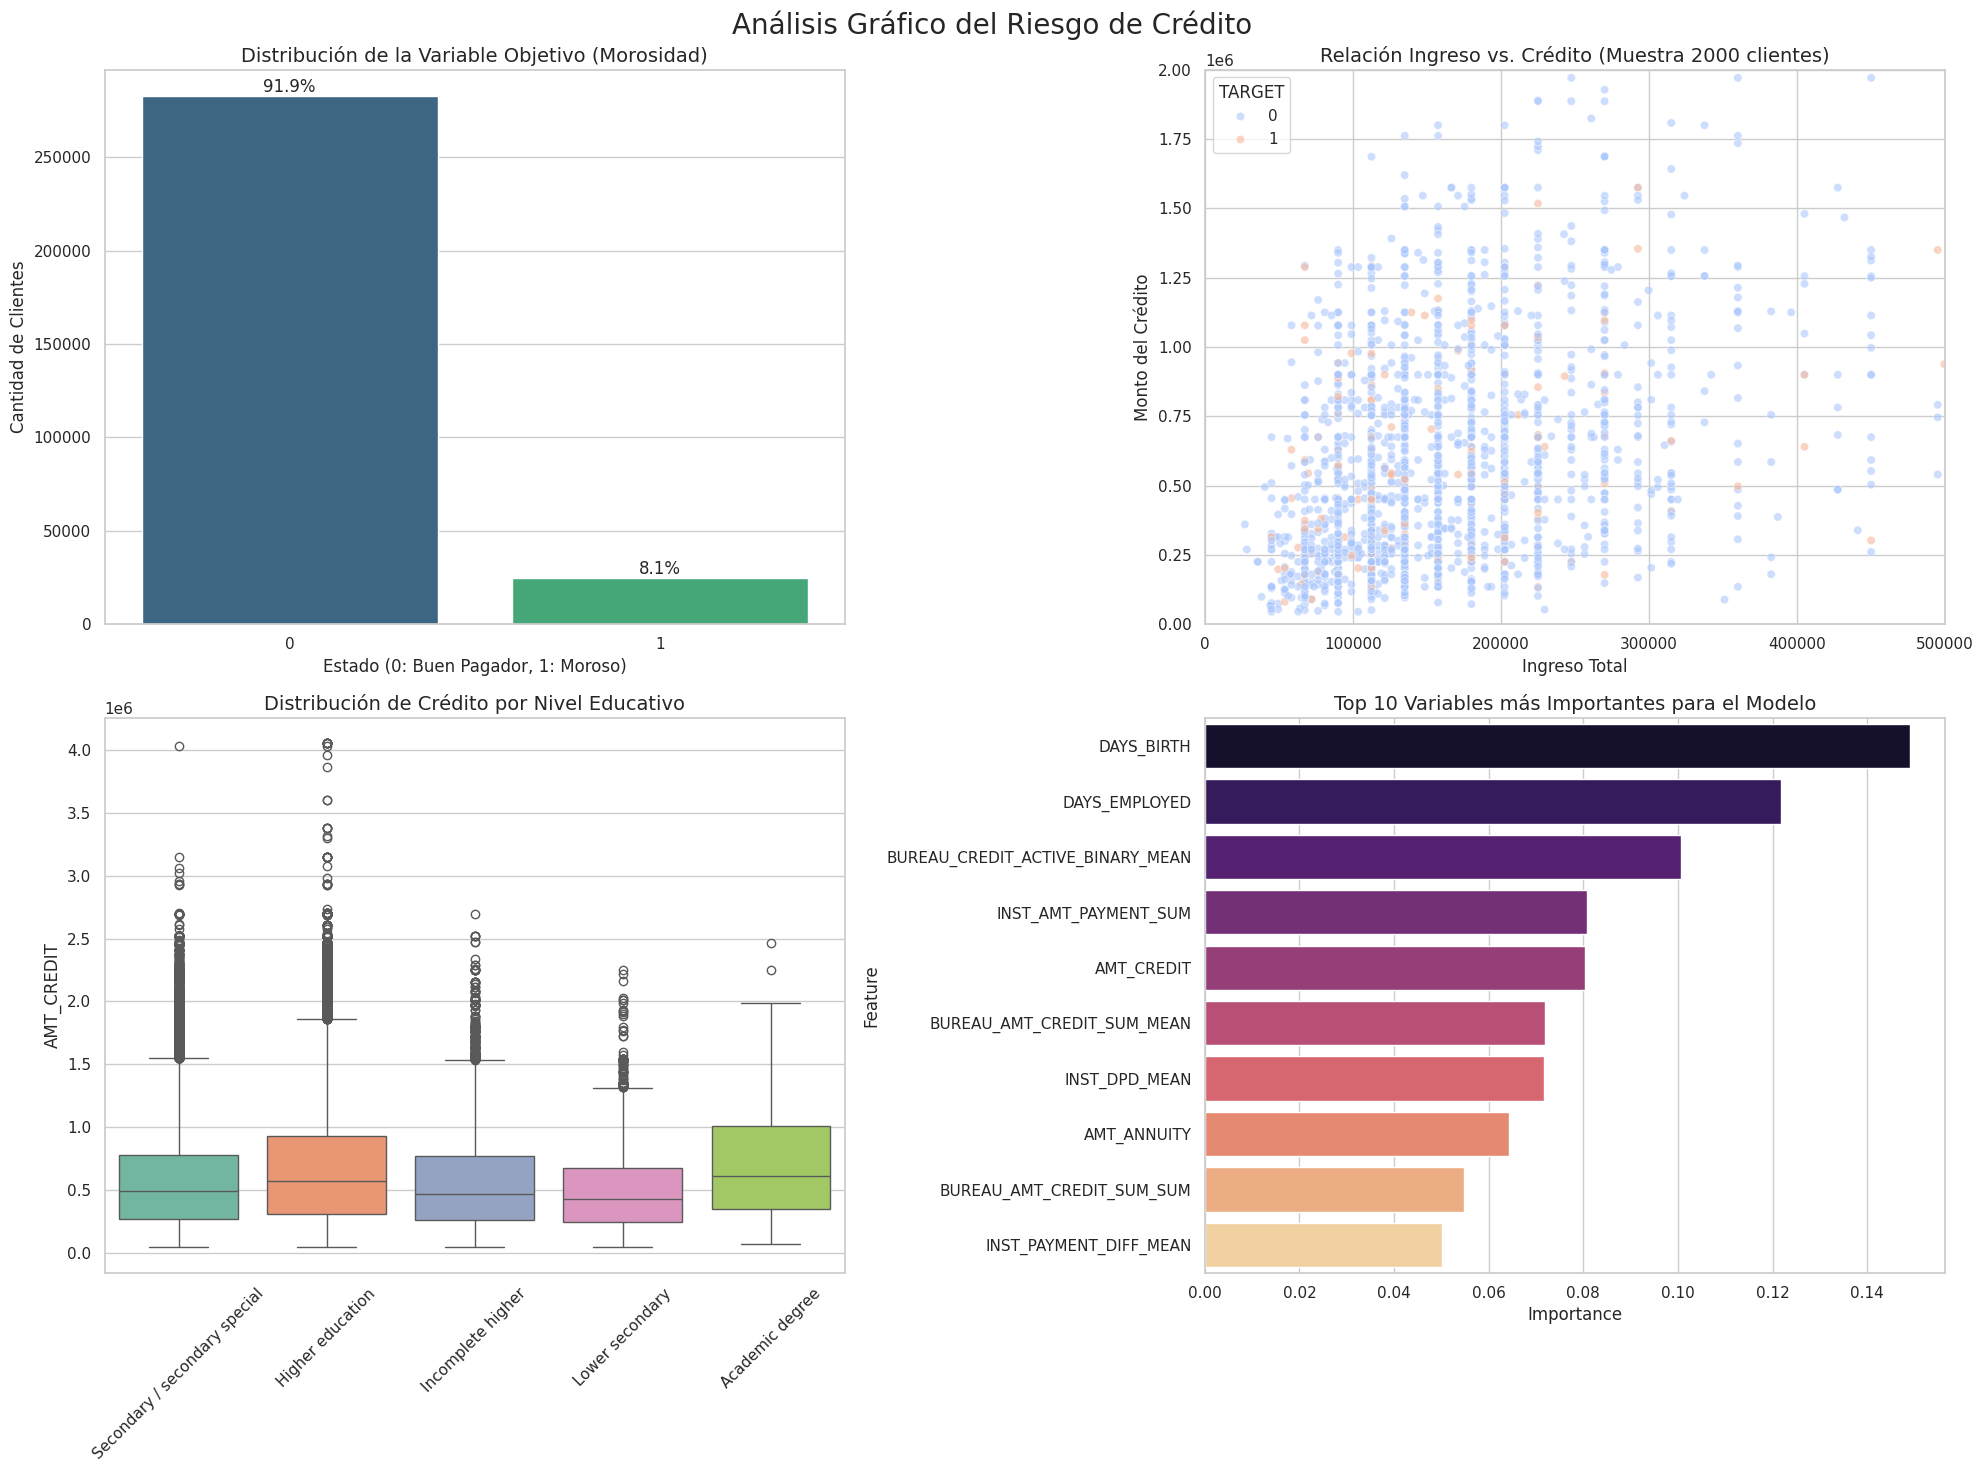

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import numpy as np
import os

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("📊 Generando Gráficos de Análisis...")

# 1. Cargar datos y modelo
try:
    # Ajusta la ruta si tus datos están en otro lado
    df = pd.read_parquet('application_.parquet')

    # Intentamos cargar el modelo para ver la importancia de variables
    artifacts_path = os.path.join(os.getcwd(), 'artifacts')
    pipeline = joblib.load(os.path.join(artifacts_path, 'model.joblib'))
    features = joblib.load(os.path.join(artifacts_path, 'features.joblib'))

    print("✅ Datos y Modelo cargados correctamente.")
except FileNotFoundError:
    print("⚠️ No se encontraron los archivos. Asegúrate de haber ejecutado el entrenamiento primero.")
    df = None

if df is not None:
    # Crear una figura con 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('Análisis Gráfico del Riesgo de Crédito', fontsize=20)

    # --- GRÁFICO 1: GRÁFICO DE BARRAS (Desbalance de Clases) ---
    # Muestra cuántos pagaron vs cuántos no (TARGET)
    sns.countplot(ax=axes[0, 0], x='TARGET', data=df, palette='viridis')
    axes[0, 0].set_title('Distribución de la Variable Objetivo (Morosidad)', fontsize=14)
    axes[0, 0].set_xlabel('Estado (0: Buen Pagador, 1: Moroso)')
    axes[0, 0].set_ylabel('Cantidad de Clientes')

    # Calcular porcentajes
    counts = df['TARGET'].value_counts(normalize=True)
    axes[0, 0].text(0, df['TARGET'].value_counts()[0], f"{counts[0]:.1%}", ha='center', va='bottom')
    axes[0, 0].text(1, df['TARGET'].value_counts()[1], f"{counts[1]:.1%}", ha='center', va='bottom')


    # --- GRÁFICO 2: GRÁFICO DE DISPERSIÓN (Scatter Plot) ---
    # Relación entre Ingresos y Monto del Crédito, coloreado por riesgo
    # Usamos una muestra para no saturar el gráfico
    df_sample = df.sample(2000, random_state=42)
    sns.scatterplot(ax=axes[0, 1], x='AMT_INCOME_TOTAL', y='AMT_CREDIT',
                    hue='TARGET', data=df_sample, alpha=0.6, palette='coolwarm')
    axes[0, 1].set_title('Relación Ingreso vs. Crédito (Muestra 2000 clientes)', fontsize=14)
    axes[0, 1].set_xlabel('Ingreso Total')
    axes[0, 1].set_ylabel('Monto del Crédito')
    # Limitamos los ejes para evitar que los millonarios deformen el gráfico
    axes[0, 1].set_xlim(0, 500000)
    axes[0, 1].set_ylim(0, 2000000)


    # --- GRÁFICO 3: BOXPLOT (Distribución por Categoría) ---
    # Compara el monto del crédito según el nivel educativo
    sns.boxplot(ax=axes[1, 0], x='NAME_EDUCATION_TYPE', y='AMT_CREDIT', data=df, palette='Set2')
    axes[1, 0].set_title('Distribución de Crédito por Nivel Educativo', fontsize=14)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].set_xlabel('')


    # --- GRÁFICO 4: IMPORTANCIA DE VARIABLES (Bar Plot Horizontal) ---
    # Extraemos qué variables usó más el modelo
    if pipeline:
        try:
            # Obtener el modelo del pipeline
            model_rf = pipeline.named_steps['model']
            importances = model_rf.feature_importances_

            # Crear DataFrame de importancia
            feature_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
            feature_imp = feature_imp.sort_values(by='Importance', ascending=False).head(10)

            sns.barplot(ax=axes[1, 1], x='Importance', y='Feature', data=feature_imp, palette='magma')
            axes[1, 1].set_title('Top 10 Variables más Importantes para el Modelo', fontsize=14)
        except:
            axes[1, 1].text(0.5, 0.5, 'No se pudo extraer la importancia de variables',
                           ha='center', va='center')

    plt.tight_layout()
    plt.show()

📊 Generando Gráficos de Evaluación del Modelo...
✅ Datos y Modelo cargados.


/tmp/ipython-input-3818985349.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f] = 0
/tmp/ipython-input-3818985349.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f] = 0
/tmp/ipython-input-3818985349.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X

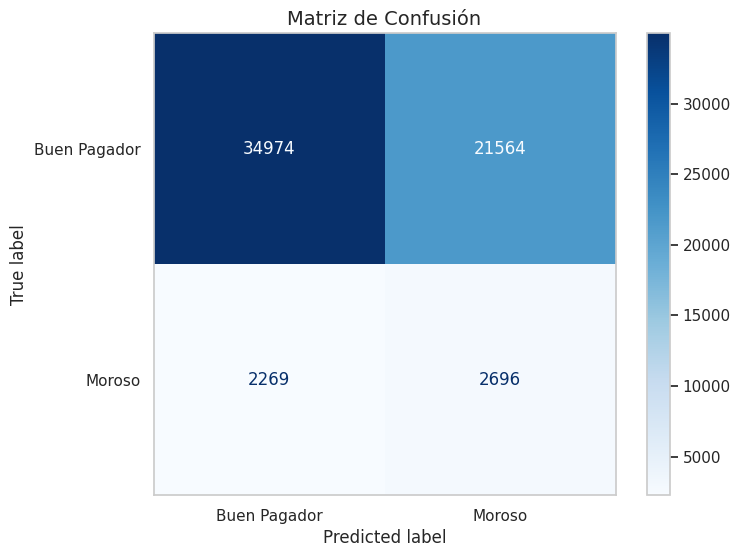

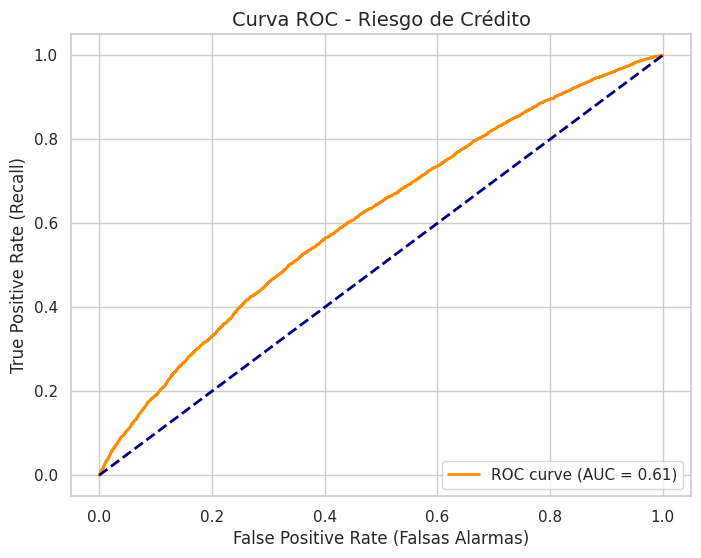

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import joblib
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

print("📊 Generando Gráficos de Evaluación del Modelo...")

# 1. Cargar datos y modelo
try:
    # Ajusta la ruta si es necesario (ej. '../data/application_.parquet')
    df = pd.read_parquet('application_.parquet')

    # Cargar artefactos (modelo y lista de features)
    artifacts_path = os.path.join(os.getcwd(), 'artifacts')
    pipeline = joblib.load(os.path.join(artifacts_path, 'model.joblib'))
    features = joblib.load(os.path.join(artifacts_path, 'features.joblib'))

    print("✅ Datos y Modelo cargados.")
except FileNotFoundError:
    print("⚠️ Error: No se encontraron los archivos. Ejecuta el entrenamiento primero.")
    df = None

if df is not None:
    # 2. Preparar datos de prueba (igual que en el entrenamiento)
    # Nota: Idealmente deberíamos usar el test set original, pero aquí lo recreamos
    # Asegúrate de que df tenga las columnas que el modelo espera.
    # Si el modelo usa features agregadas (INST_...), este paso fallará si solo cargas application_.
    # Para simplificar la visualización rápida, usaremos solo las columnas que existan en df y rellenaremos el resto.

    # Filtrar solo columnas que tenemos disponibles en application_
    available_features = [f for f in features if f in df.columns]
    X = df[available_features]

    # Rellenar columnas faltantes (las de bureau/installments) con 0 para poder predecir
    missing_features = [f for f in features if f not in df.columns]
    for f in missing_features:
        X[f] = 0

    # Reordenar columnas como espera el modelo
    X = X[features]
    y = df['TARGET']

    # Split (usamos random_state=42 para que sea igual al entrenamiento)
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 3. Predicciones
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # --- GRÁFICO 1: MATRIZ DE CONFUSIÓN ---
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buen Pagador', 'Moroso'])

    # Plot con colores azules como en tu imagen
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title('Matriz de Confusión', fontsize=14)
    plt.grid(False) # Quitar rejilla para limpieza
    plt.show()

    # --- GRÁFICO 2: CURVA ROC ---
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate (Falsas Alarmas)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Curva ROC - Riesgo de Crédito', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

📊 Generando Visualización de Clusters (PCA)...


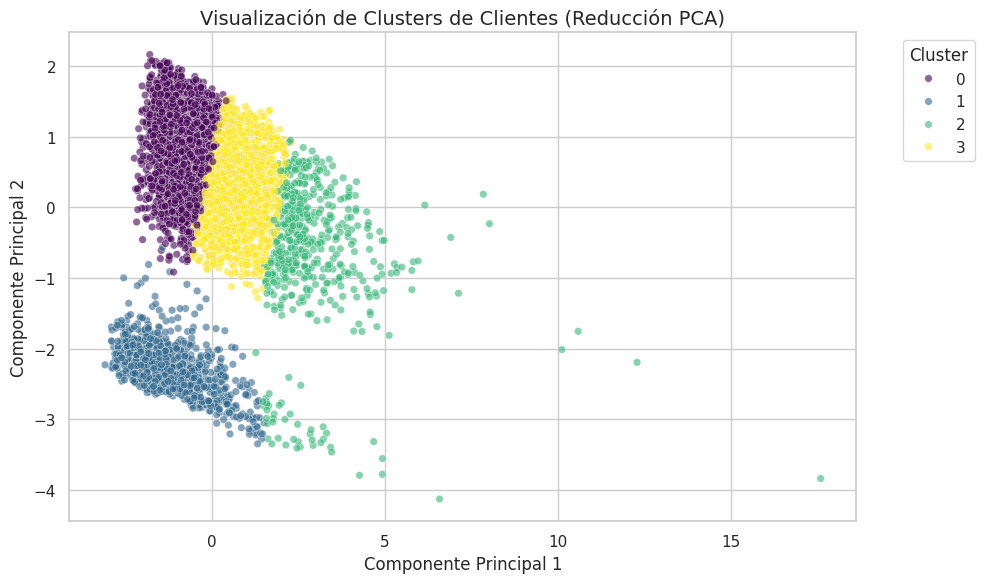

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print("📊 Generando Visualización de Clusters (PCA)...")

if df is not None:
    # 1. Selección de variables para clustering (Perfil financiero)
    cluster_features = [
        'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
        'DAYS_BIRTH', 'DAYS_EMPLOYED'
    ]

    # Tomamos una muestra para que el gráfico no sea tan pesado y se vea mejor
    # (El gráfico original parece tener pocos puntos o una muestra)
    df_cluster = df[cluster_features].sample(5000, random_state=42).copy()

    # Limpieza básica (llenar nulos)
    df_cluster = df_cluster.fillna(df_cluster.median())

    # 2. Estandarización (Importante para K-Means y PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_cluster)

    # 3. K-Means (4 Clusters como en tu ejemplo)
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)

    # 4. Reducción de Dimensionalidad (PCA) a 2 componentes
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Crear DataFrame para graficar
    df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    df_pca['Cluster'] = clusters

    # 5. Graficar
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='PC1', y='PC2',
        hue='Cluster',
        data=df_pca,
        palette='viridis', # Paleta de colores similar a tu imagen
        alpha=0.6,
        s=30 # Tamaño de puntos
    )

    plt.title('Visualización de Clusters de Clientes (Reducción PCA)', fontsize=14)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

Explicación de lo que verás:
Matriz de Confusión: Te mostrará cuántos clientes clasificó correctamente. Dado el desbalance, verás muchos aciertos en "Buen Pagador" (Cuadrante superior izquierdo) y el reto estará en detectar los "Morosos" (Cuadrante inferior derecho).

Curva ROC: La línea naranja muestra qué tan bueno es tu modelo separando clases. Cuanto más se aleje de la línea punteada azul hacia arriba, mejor es el modelo (AUC mayor a 0.5).

Clusters PCA: Verás grupos de clientes.

Los puntos amarillos (o de un color muy separado) suelen ser outliers (clientes con ingresos o créditos extremadamente altos).

Los grupos centrales representan los perfiles típicos de clientes (ingresos medios/bajos).